# Evaluación sobre verdad de campo original

In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from sqlite3 import connect
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from utilities import *

In [2]:

data1 = pd.read_csv('../data/train/12544_samples.csv')
data2= pd.read_csv('../data/train/00000_samples.csv')
data = data2.append(data1)

In [3]:
data.head()

,in1,id,cultivo,originfid,band_0,band_1,band_2,band_3,band_4,band_5,...,band_212,band_213,band_214,band_215,band_216,band_217,band_218,band_219,band_220,band_221
0,14084,5,GIRASOL,254,-0.025667,-0.032823,-0.012369,0.438167,0.640188,0.603974,...,-0.193028,0.178172,0.635229,0.562005,-0.739955,-0.745478,-0.739978,-0.294296,0.245570,0.161900
1,14084,1,SOJA,14,0.031207,-0.007179,0.029374,0.450892,0.606595,0.134590,...,-0.218211,0.377205,0.593264,-0.122388,-0.721911,-0.742229,-0.722744,0.089114,0.487397,-0.625130
2,14084,2,MAIZ,13,-0.000126,-0.022707,-0.034181,0.333374,0.610177,0.537418,...,-0.217263,0.034658,0.481159,0.282209,-0.758681,-0.757710,-0.753018,-0.385281,0.331265,0.065245
3,14084,2,MAIZ,15,-0.037434,-0.039979,-0.039999,0.444946,0.583272,0.476345,...,-0.237244,0.273779,0.470738,0.139566,-0.755049,-0.755201,-0.755880,-0.059853,0.278529,-0.186228
4,14084,2,MAIZ,16,-0.042109,-0.049618,-0.051460,0.468945,0.557798,0.421010,...,-0.211147,0.432482,0.487864,0.060102,-0.748104,-0.758429,-0.755831,0.066667,0.243937,-0.282177


In [4]:
model = joblib.load('../model/randomforest_iter_01.joblib')

In [5]:
X = data.filter(regex='band_').to_numpy()
y = data['id'].to_numpy()

In [6]:
y_hat = model.predict_proba(X)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


In [7]:
with open(f'../predictions/randomforest_probas_train.npy', 'wb') as f:
    np.save(f, y_hat)

In [8]:
max_probas = y_hat.max(axis=1)
classes = [model.classes_[a] for a in y_hat.argmax(axis=1)]

In [9]:
data = data.assign(pred_class=classes, pred_score=max_probas)

In [10]:
true_preds = data[data.id==data.pred_class]
min_score = true_preds.pred_score.min()

In [11]:
with open(f'../predictions/randomforest_minscore_train.npy', 'wb') as f:
    np.save(f, min_score)

In [12]:
print(f'{len(true_preds)}/{len(data)} pixeles fueron correctamente predichos.')
print(f'El mínimo score de predicción fue: {min_score}')

466/466 pixeles fueron correctamente predichos.
El mínimo score de predicción fue: 0.5638284325656424


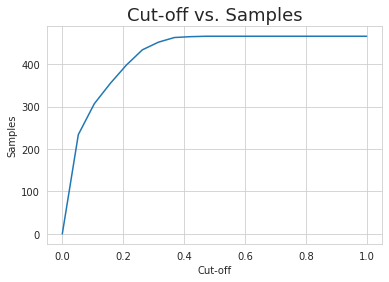

In [13]:
cutt_off = []
samples = []
for i in np.linspace(0,1,20):
    data['mask'] = data.pred_score.apply(lambda x: True if x>1-i else False)
    cantidades = data[(data.id==data.pred_class) & (data['mask']==True)].shape[0]
    cutt_off.append(i)
    samples.append(cantidades)


sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=cutt_off, y=samples)
plt.xlabel('Cut-off')
plt.ylabel('Samples')
plt.title('Cut-off vs. Samples', fontsize=18)
plt.savefig('../predictions/randomforest_train_cutoff.png')